# Softmax 分类器练习

*请将这份完整的练习表（包括所有输出结果以及表格外部的支持代码）随本次作业一并提交。更多详情见课程官网的[作业页面](http://vision.stanford.edu/teaching/cs231n/assignments.html)。*

在本练习中，你将：

- 实现 Softmax 分类器的**完全向量化损失函数**。
- 实现其**解析梯度**的完全向量化表达式。
- 使用数值梯度**验证你的实现**。
- 使用验证集**调整学习率和正则化强度**。
- 使用**随机梯度下降（SGD）**优化损失函数。
- **可视化**最终学习到的权重。


In [1]:
# 运行本 notebook 所需的初始化代码

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10   # 加载 CIFAR-10 数据的工具函数
import matplotlib.pyplot as plt

# 让 matplotlib 图形直接嵌入在 notebook 中，而不是弹出新窗口
%matplotlib inline
# 统一设置图片默认大小，便于查看
plt.rcParams['figure.figsize'] = (10.0, 8.0)
# 关闭插值，使像素边界更清晰
plt.rcParams['image.interpolation'] = 'nearest'
# 灰度图默认使用灰度色图
plt.rcParams['image.cmap'] = 'gray'

# 开启 IPython 的自动重载功能：修改外部 .py 文件后无需重启 kernel 即可生效
# 官方讨论贴地址：http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# 注意：由于网络原因，上述链接暂时无法成功解析。如果你需要查看该网页内容，
# 请检查链接是否有效，或稍后重试；若不需要查看，可直接继续后续操作。
%load_ext autoreload
%autoreload 2

## CIFAR-10 数据加载与预处理

In [2]:
# 加载原始 CIFAR-10 数据
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# 如果之前已加载过数据，先删除相关变量，防止重复加载导致内存占用过高
try:
    del X_train, y_train
    del X_test, y_test
    print('已清空之前加载的数据。')
except:
    pass

# 真正从磁盘读取 CIFAR-10
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# 简单检查：打印训练集和测试集的形状
print('训练数据形状: ', X_train.shape)
print('训练标签形状: ', y_train.shape)
print('测试数据形状: ', X_test.shape)
print('测试标签形状: ', y_test.shape)

训练数据形状:  (50000, 32, 32, 3)
训练标签形状:  (50000,)
测试数据形状:  (10000, 32, 32, 3)
测试标签形状:  (10000,)


d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39134 (\N{CJK UNIFIED IDEOGRAPH-98DE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26426 (\N{CJK UNIFIED IDEOGRAPH-673A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27773 (\N{CJK UNIFIED IDEOGRAPH-6C7D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36710 (\N{CJK UNIFIED IDEOGRAPH-8F66}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 40479 (\N{CJK UNIFIED IDEOGRAPH-9E1F}) missing from font(s) DejaVu Sans.
  

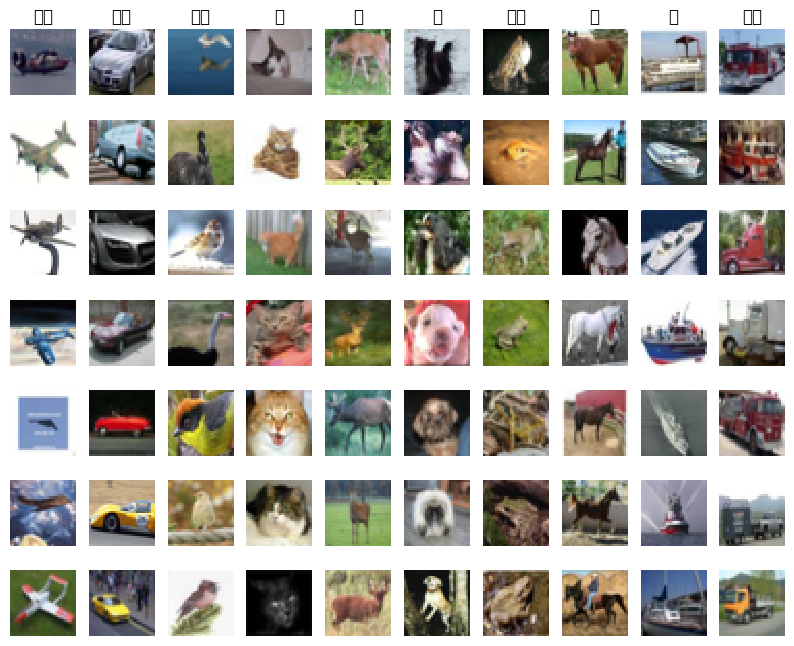

In [3]:
# 可视化数据集中的一些样本
# 从每个类别中随机展示若干张训练图像

classes = ['飞机', '汽车', '鸟类', '猫', '鹿', '狗', '青蛙', '马', '船', '卡车']
num_classes = len(classes)              # 类别数（10）
samples_per_class = 7                   # 每类展示 7 张图

for y, cls in enumerate(classes):
    # 找到所有属于当前类别的训练样本索引
    idxs = np.flatnonzero(y_train == y)
    # 随机选择 7 张且不重复
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    
    for i, idx in enumerate(idxs):
        # 计算子图位置
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        # 显示图像
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        # 只在第一行写类别名
        if i == 0:
            plt.title(cls)

plt.show()

In [4]:
# 将数据划分为训练集、验证集和测试集。此外，我们还将从训练集中创建一个小型开发集，
# 作为训练集的一个子集；我们可以在开发过程中使用这个开发集，这样代码运行会更快。
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# 验证集是从原始训练集中选取的 num_validation 个样本
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# 训练集是从原始训练集中选取的前 num_training 个样本
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# 开发集是从训练集中随机选取的 num_dev 个样本
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# 测试集是从原始测试集中选取的前 num_test 个样本
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

# 打印各数据集的形状
print('训练数据形状: ', X_train.shape)
print('训练标签形状: ', y_train.shape)
print('验证数据形状: ', X_val.shape)
print('验证标签形状: ', y_val.shape)
print('测试数据形状: ', X_test.shape)
print('测试标签形状: ', y_test.shape)

训练数据形状:  (49000, 32, 32, 3)
训练标签形状:  (49000,)
验证数据形状:  (1000, 32, 32, 3)
验证标签形状:  (1000,)
测试数据形状:  (1000, 32, 32, 3)
测试标签形状:  (1000,)


In [5]:
# 预处理：将图像数据展平成行向量
X_train = np.reshape(X_train, (X_train.shape[0], -1))  # 展平训练集
X_val   = np.reshape(X_val,   (X_val.shape[0],   -1))  # 展平验证集
X_test  = np.reshape(X_test,  (X_test.shape[0],  -1))  # 展平测试集
X_dev   = np.reshape(X_dev,   (X_dev.shape[0],   -1))  # 展平开发集

# 简单检查：打印各数据集的形状
print('训练数据形状: ', X_train.shape)
print('验证数据形状: ', X_val.shape)
print('测试数据形状: ', X_test.shape)
print('开发数据形状: ', X_dev.shape)

训练数据形状:  (49000, 3072)
验证数据形状:  (1000, 3072)
测试数据形状:  (1000, 3072)
开发数据形状:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


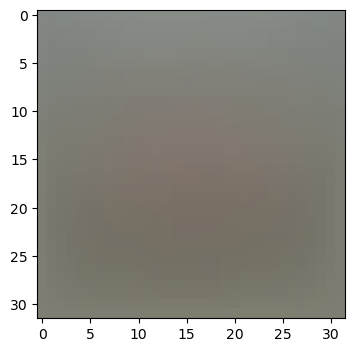

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# 预处理：减去均值图像
# 首先：根据训练数据计算均值图像
mean_image = np.mean(X_train, axis=0)  # 按列计算均值
print(mean_image[:10])  # 打印前 10 个元素
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((32, 32, 3)).astype('uint8'))  # 可视化均值图像
plt.show()

# 其次：从训练数据和测试数据中减去均值图像
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# 最后：添加偏置维度（全为 1 的列），即偏置技巧，这样分类器只需优化一个权重矩阵 W。
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

# 打印各数据集的形状
print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## Softmax 分类器

本节的所有代码都将写在 `cs231n/classifiers/softmax.py` 文件中。

正如你所看到的，我们已经预先填充了函数 `softmax_loss_naive`，它使用 for 循环来计算 Softmax 损失函数。

In [7]:
# 测试我们提供的朴素 Softmax 损失函数实现
from cs231n.classifiers.softmax import softmax_loss_naive
import time

# 生成一个随机的 Softmax 分类器权重矩阵，数值很小
W = np.random.randn(3073, 10) * 0.0001

# 计算损失和梯度
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
print('损失: %f' % loss)

# 简单检查：损失值应接近 -log(0.1)
print('损失: %f' % loss)
print('合理性检查: %f' % (-np.log(0.1)))

损失: 2.346040
损失: 2.346040
合理性检查: 2.302585


**内联问题 1**

为什么我们期望损失接近 -log(0.1)？请简要解释。

$\color{blue}{\textit{你的答案：}}$ *请在此处填写*


In [8]:
#1/10的概率

目前，上述函数返回的 `grad` 全部为零。  
请推导并实现 softmax 损失函数的梯度，并在 `softmax_loss_naive` 函数内部直接完成实现。  
建议将新代码穿插在现有函数中，而非重写整个函数。

为了验证你的梯度实现是否正确，可以利用数值方法估计损失函数的梯度，并将其与你计算出的解析梯度进行比较。  
我们已为你提供了相应的检查代码：

In [9]:
# 一旦你实现了梯度，请用下面的代码重新计算
# 并用我们提供的函数进行梯度检查

# 计算当前权重 W 下的损失及梯度（无正则化）
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# 在若干随机维度上数值计算梯度，并与解析梯度对比；
# 两者应在所有维度上几乎完全一致。
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# 再次进行梯度检查，这次开启正则化；
# 别忘了正则项的梯度也要一起实现！
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

数值梯度: 1.859823, 解析梯度: 1.859823, 相对误差: 4.823433e-08
数值梯度: 0.133114, 解析梯度: 0.133114, 相对误差: 3.433650e-09
数值梯度: 1.925703, 解析梯度: 1.925703, 相对误差: 4.622287e-08
数值梯度: -1.194446, 解析梯度: -1.194446, 相对误差: 3.782502e-08
数值梯度: 2.019982, 解析梯度: 2.019982, 相对误差: 1.739205e-08
数值梯度: 0.123686, 解析梯度: 0.123686, 相对误差: 6.459688e-08
数值梯度: -1.278163, 解析梯度: -1.278164, 相对误差: 2.844909e-08
数值梯度: -1.321662, 解析梯度: -1.321662, 相对误差: 1.664442e-08
数值梯度: 0.343406, 解析梯度: 0.343406, 相对误差: 4.128044e-08
数值梯度: 1.026060, 解析梯度: 1.026060, 相对误差: 3.078419e-08
数值梯度: -0.777583, 解析梯度: -0.777583, 相对误差: 2.062672e-08
数值梯度: 3.089280, 解析梯度: 3.089280, 相对误差: 1.570965e-08
数值梯度: -1.188806, 解析梯度: -1.188806, 相对误差: 2.485893e-08
数值梯度: 0.562185, 解析梯度: 0.562185, 相对误差: 1.638292e-07
数值梯度: 0.080357, 解析梯度: 0.080357, 相对误差: 1.263534e-07
数值梯度: 0.207231, 解析梯度: 0.207231, 相对误差: 1.732018e-07
数值梯度: 0.846667, 解析梯度: 0.846667, 相对误差: 4.553078e-08
数值梯度: 0.734148, 解析梯度: 0.734148, 相对误差: 1.827563e-09
数值梯度: 2.797325, 解析梯度: 2.797325, 相对误差: 1.357017e-08
数值梯度: 0.889279, 解析梯度:

**内联问题 2**

尽管 gradcheck 对于 Softmax 损失通常是可靠的，但在 SVM 损失上偶尔会出现某个维度与数值梯度不完全匹配的情况。  
这种差异可能由什么原因引起？是否需要担心？  
请举一个最简单的一维例子说明 SVM 损失梯度检查可能失败的情形。  
改变 margin Δ 会如何影响这种现象的出现频率？

提示：SVM 损失函数在严格意义上并不可微。

$\color{blue}{\textit{你的答案：}}$ *请在此处填写*
##根本原因： SVM损失函数使用了max(0, x)函数，在x=0处不可微



In [10]:
# 接下来实现 softmax_loss_vectorized 函数；目前只需计算损失值，
# 稍后再实现梯度。
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('朴素实现损失: %e，耗时 %f 秒' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, _ = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('向量化实现损失: %e，耗时 %f 秒' % (loss_vectorized, toc - tic))

# 两种实现计算出的损失值应一致，但向量化版本应快得多。
print('损失差值: %f' % (loss_naive - loss_vectorized))

朴素实现损失: 2.346040e+00，耗时 0.097237 秒
向量化实现损失: 2.346040e+00，耗时 0.000000 秒
损失差值: -0.000000


In [11]:
# 补全 softmax_loss_vectorized 的实现，并以向量化方式计算损失函数的梯度。

# 朴素实现与向量化实现应得到相同结果，但向量化版本速度应更快。
tic = time.time()
_, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('朴素实现损失与梯度：耗时 %f 秒' % (toc - tic))

tic = time.time()
_, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('向量化实现损失与梯度：耗时 %f 秒' % (toc - tic))

# 损失是一个标量，直接比较即可；梯度是矩阵，用 Frobenius 范数比较。
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('梯度差异: %f' % difference)

朴素实现损失与梯度：耗时 0.091012 秒
向量化实现损失与梯度：耗时 0.000000 秒
梯度差异: 0.000000


### 随机梯度下降（SGD）

我们现在已经得到了向量化且高效计算损失、梯度的实现，并且梯度与数值梯度一致，因此可以使用随机梯度下降（SGD）来最小化损失。  
本部分的代码将写在 `cs231n/classifiers/linear_classifier.py` 中。

In [12]:
# 在文件 linear_classifier.py 中，请在函数 LinearClassifier.train() 里实现 SGD，
# 然后用以下代码运行它。

from cs231n.classifiers import Softmax
softmax = Softmax()                 # 创建 Softmax 分类器实例

tic = time.time()
# 开始训练，使用给定的学习率、正则化系数，迭代 1500 次，并打印日志
loss_hist = softmax.train(
    X_train, y_train,
    learning_rate=1e-7,
    reg=2.5e4,
    num_iters=1500,
    verbose=True
)
toc = time.time()
print('训练耗时 %f 秒' % (toc - tic))

iteration 0 / 1500: loss 763.075202
iteration 100 / 1500: loss 280.328898
iteration 200 / 1500: loss 103.823964
iteration 300 / 1500: loss 39.354889
iteration 400 / 1500: loss 15.785767
iteration 500 / 1500: loss 7.059367
iteration 600 / 1500: loss 3.874863
iteration 700 / 1500: loss 2.737588
iteration 800 / 1500: loss 2.343894
iteration 900 / 1500: loss 2.170333
iteration 1000 / 1500: loss 2.070288
iteration 1100 / 1500: loss 2.110867
iteration 1200 / 1500: loss 2.081586
iteration 1300 / 1500: loss 2.085559
iteration 1400 / 1500: loss 2.100146
训练耗时 2.989359 秒


d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36845 (\N{CJK UNIFIED IDEOGRAPH-8FED}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  

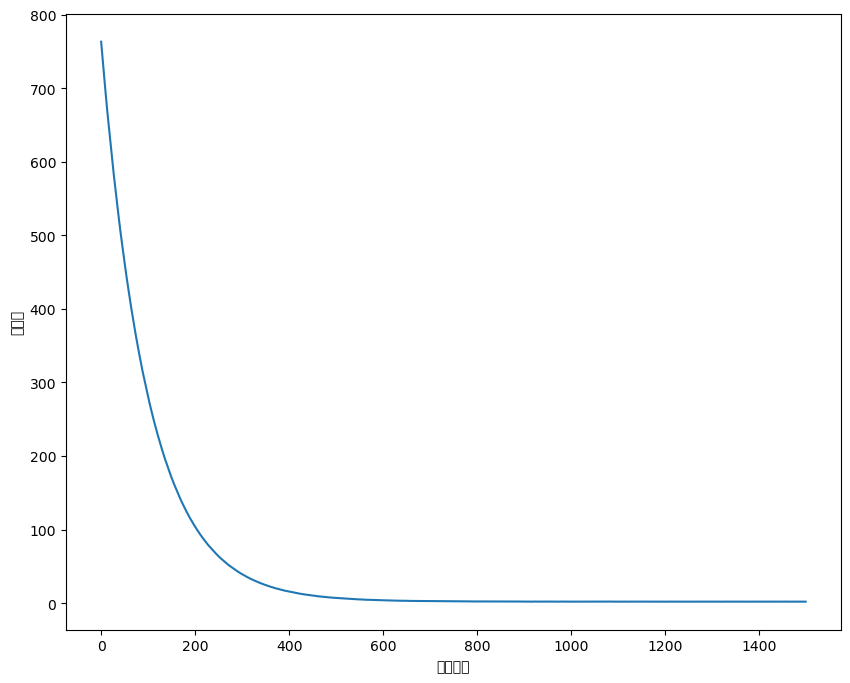

In [13]:
# 一种实用的调试策略是把损失值随迭代次数画出来
plt.plot(loss_hist)
plt.xlabel('迭代次数')
plt.ylabel('损失值')
plt.show()

In [14]:
# 实现 LinearClassifier.predict 函数，并评估在训练集和验证集上的表现
# 你应在验证集上获得约 0.34 (> 0.33) 的准确率

# 在训练集上预测
y_train_pred = softmax.predict(X_train)
print('训练准确率: %f' % (np.mean(y_train == y_train_pred), ))

# 在验证集上预测
y_val_pred = softmax.predict(X_val)
print('验证准确率: %f' % (np.mean(y_val == y_val_pred), ))

训练准确率: 0.328469
验证准确率: 0.339000


In [15]:
# 将训练好的模型保存，以便自动评分器使用
softmax.save("softmax.npy")

softmax.npy 已保存。


In [17]:
# 使用验证集来调优超参数（正则化强度和学习率）。
# 建议尝试不同的学习率和正则化强度范围；认真调参后，
# 你应在验证集上得到约 0.365（> 0.36）的准确率。
#
# 注意：在超参数搜索过程中可能会出现运行时/溢出警告，
# 这通常是由极端值引起的，并不是 bug。

# results 是一个字典，以 (learning_rate, regularization_strength) 为键，
# 对应的值为 (training_accuracy, validation_accuracy)。
# 准确率定义为被正确分类的数据点所占的比例。
results = {}
best_val = -1        # 目前观察到的最高验证准确率
best_softmax = None  # 达到最高验证准确率的 Softmax 对象

################################################################################
# 代办:                                                                         #
# 编写代码，在验证集上调优超参数。对于每一组超参数组合，                           #
# 在训练集上训练一个 Softmax 分类器，计算其在训练集和验证集上的准确率，            #
# 并将结果存入 results 字典。此外，将最高验证准确率存入 best_val，                #
# 并将达到该准确率的 Softmax 对象存入 best_softmax。                             #
#                                                                              #
# 提示：开发验证代码时可使用较小的 num_iters，这样训练更快；                      #
# 确认代码正确后，再用更大的 num_iters 重新运行。                                #
################################################################################
results = {}
best_val = -1
best_softmax = None
from cs231n.classifiers.linear_classifier import Softmax

learning_rates = [5e-8, 1e-7, 5e-7, 1e-6, 5e-6]
regularization_strengths = [5e3, 1e4, 2.5e4, 5e4]

num_iters_search = 800   # 增大到 1500 可再提升效果

results = {}
best_val = -1.0
best_softmax = None

for lr in learning_rates:
    for reg in regularization_strengths:
        clf = Softmax()
        clf.train(
            X_train, y_train,
            learning_rate=lr,
            reg=reg,
            num_iters=num_iters_search,
            batch_size=200,
            verbose=False
        )
        train_acc = np.mean(clf.predict(X_train) == y_train)
        val_acc   = np.mean(clf.predict(X_val) == y_val)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = clf

for (lr, reg) in sorted(results):
    ta, va = results[(lr, reg)]
    print('lr %e reg %e 训练准确率: %.4f 验证准确率: %.4f' % (lr, reg, ta, va))

print('最佳验证准确率: %.4f' % best_val)
################################################################################

# 以下超参数仅供参考，你可以根据需要自行调整
learning_rates = [1e-7, 1e-6]
regularization_strengths = [2.5e4, 1e4]

# 打印最终结果
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e 训练准确率: %f 验证准确率: %f' %
          (lr, reg, train_accuracy, val_accuracy))

print('交叉验证期间达到的最佳验证准确率: %f' % best_val)

lr 5.000000e-08 reg 5.000000e+03 训练准确率: 0.2148 验证准确率: 0.2320
lr 5.000000e-08 reg 1.000000e+04 训练准确率: 0.2172 验证准确率: 0.2220
lr 5.000000e-08 reg 2.500000e+04 训练准确率: 0.2829 验证准确率: 0.2820
lr 5.000000e-08 reg 5.000000e+04 训练准确率: 0.3042 验证准确率: 0.3210
lr 1.000000e-07 reg 5.000000e+03 训练准确率: 0.2620 验证准确率: 0.2720
lr 1.000000e-07 reg 1.000000e+04 训练准确率: 0.3088 验证准确率: 0.3110
lr 1.000000e-07 reg 2.500000e+04 训练准确率: 0.3295 验证准确率: 0.3440
lr 1.000000e-07 reg 5.000000e+04 训练准确率: 0.3018 验证准确率: 0.3210
lr 5.000000e-07 reg 5.000000e+03 训练准确率: 0.3713 验证准确率: 0.3820
lr 5.000000e-07 reg 1.000000e+04 训练准确率: 0.3525 验证准确率: 0.3580
lr 5.000000e-07 reg 2.500000e+04 训练准确率: 0.3257 验证准确率: 0.3480
lr 5.000000e-07 reg 5.000000e+04 训练准确率: 0.3018 验证准确率: 0.3190
lr 1.000000e-06 reg 5.000000e+03 训练准确率: 0.3593 验证准确率: 0.3740
lr 1.000000e-06 reg 1.000000e+04 训练准确率: 0.3494 验证准确率: 0.3540
lr 1.000000e-06 reg 2.500000e+04 训练准确率: 0.3108 验证准确率: 0.3290
lr 1.000000e-06 reg 5.000000e+04 训练准确率: 0.3069 验证准确率: 0.3290
lr 5.000000e-06 reg 5.00

d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21017 (\N{CJK UNIFIED IDEOGRAPH-5219}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24378 (\N{CJK UNIFIED IDEOGRAPH-5F3A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\Conda\envs\torch_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  

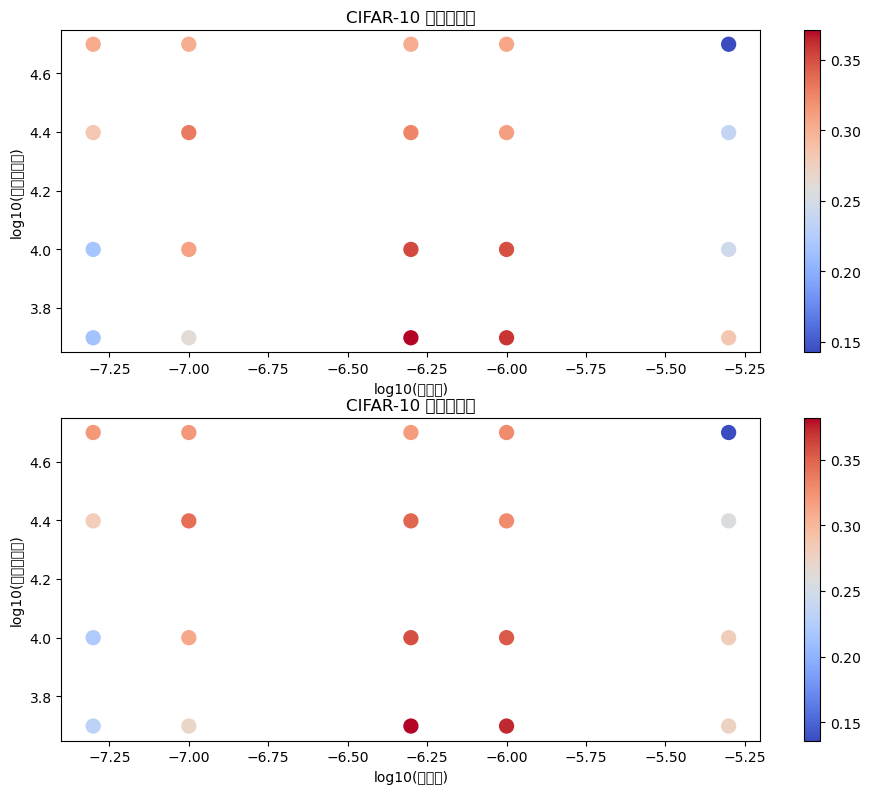

In [18]:
# 可视化交叉验证结果
import math
import pdb

# pdb.set_trace()

# 将学习率和正则化强度取对数，方便作图
x_scatter = [math.log10(x[0]) for x in results]   # log10(learning_rate)
y_scatter = [math.log10(x[1]) for x in results]   # log10(regularization_strength)

marker_size = 100

# 绘制训练准确率热力图
colors = [results[x][0] for x in results]                # 训练准确率
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log10(学习率)')
plt.ylabel('log10(正则化强度)')
plt.title('CIFAR-10 训练准确率')

# 绘制验证准确率热力图
colors = [results[x][1] for x in results]                # 验证准确率
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log10(学习率)')
plt.ylabel('log10(正则化强度)')
plt.title('CIFAR-10 验证准确率')
plt.show()

In [19]:
# 在测试集上评估最优 Softmax 模型
y_test_pred = best_softmax.predict(X_test)               # 预测测试集标签
test_accuracy = np.mean(y_test == y_test_pred)           # 计算测试准确率
print('基于原始像素的 Softmax 分类器最终测试集准确率: %f' % test_accuracy)

基于原始像素的 Softmax 分类器最终测试集准确率: 0.363000


In [20]:
# 保存最优的 Softmax 模型
best_softmax.save("best_softmax.npy")

best_softmax.npy 已保存。


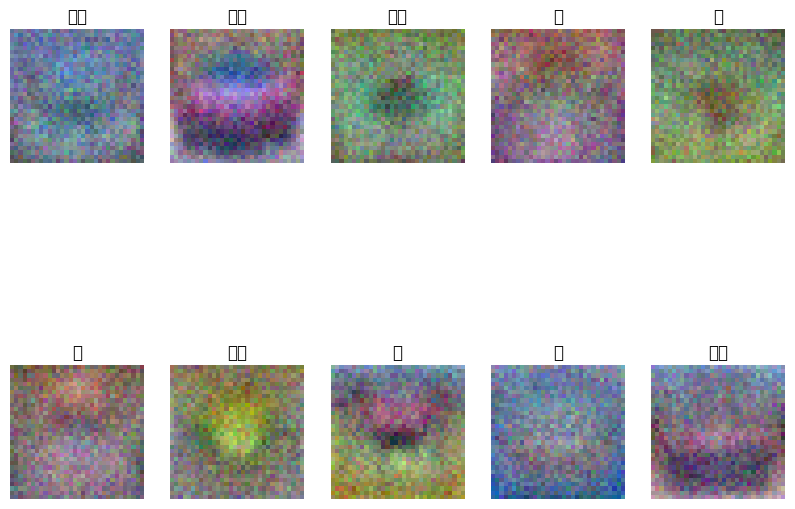

In [21]:
# 可视化每个类别学习到的权重（模板）
# 权重的美观程度取决于你选择的学习率和正则化强度
w = best_softmax.W[:-1, :]           # 去掉偏置项
w = w.reshape(32, 32, 3, 10)         # 重新调整形状为 (32,32,3,10)

w_min, w_max = np.min(w), np.max(w)  # 找到最小、最大值用于归一化
classes = ['飞机', '汽车', '鸟类', '猫', '鹿',
           '狗', '青蛙', '马', '船', '卡车']

for i in range(10):
    plt.subplot(2, 5, i + 1)

    # 将权重线性缩放到 0–255 之间，便于显示
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

plt.show()

**内联问题 3**

请描述你可视化的 Softmax 分类器权重看起来像什么，并简要解释为什么它们看起来是这样的。

$\color{blue}{\textit{你的答案：}}$ *请在此处填写*


**内联问题 4** - **判断题**

假设整体训练损失定义为所有训练样本的每个样本损失之和。有可能添加一个新数据点到训练集中，会改变 Softmax 损失，但不会改变 SVM 损失。

$\color{blue}{\textit{你的答案：}}$


$\color{blue}{\textit{你的解释：}}$

